<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Create-pycortex-vertex-objects" data-toc-modified-id="Create-pycortex-vertex-objects-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create pycortex vertex objects</a></span></li><li><span><a href="#Create-figures-etc" data-toc-modified-id="Create-figures-etc-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create figures etc</a></span></li></ul></div>

In [1]:
import cortex as cx
import nilearn.surface as surface
import pandas as pd
import numpy as np
import os, shutil, shlex, subprocess
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib import cm

# needs prfpy for prf spatial plot, and for model predictions at some point
from prfpy.rf import gauss2D_iso_cart
from prfpy.model import Iso2DGaussianModel

%matplotlib notebook

### Parameters

In [2]:
hemis = ['L', 'R']
hemi_names = ['left', 'right']

prf_par_names = ['x', 'y', 'size', 'beta', 'baseline', 'rsq']

subject = 'hcp_999999'
# data_dir = '/Users/knapen/projects/prf_viz/data'
data_dir = os.path.join(os.environ['HOME'], 'projects/prf_viz/data')

tc_gii_filename = 'tfMRI_{run_name}_7T_AP_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries_sg_psc_{hemi}.gii'
# prf_gii_filename = 'retmap_results_barmean_iterative.scalar.{hemi}.gii'
prf_gii_filename = 'V12_retmap_results_polar_bar_iterative.scalar.{hemi}.gii'
design_matrix_filename = '7T_{run_name}_small.hdf5'

run_name = 'RETBAR1'
flatmap_height = 2048
full_figsize = (12, 8)

vf_extent = [-8, 8]
nr_vf_pix = 200
prf_space_x, prf_space_y = np.meshgrid(np.linspace(vf_extent[0], vf_extent[1], nr_vf_pix, endpoint=True),
                                       np.linspace(vf_extent[0], vf_extent[1], nr_vf_pix, endpoint=True))

### Load data
timecourses, prf parameters, and design matrix.

In [3]:
tc_data = np.vstack([surface.load_surf_data(os.path.join(data_dir, tc_gii_filename.format(
    run_name=run_name, hemi=hemi))) for hemi in hemis])

prf_pars = np.vstack([surface.load_surf_data(os.path.join(
    data_dir, prf_gii_filename.format(hemi=hemi))) for hemi in hemis])
prf_pars_df = pd.DataFrame(prf_pars, columns=prf_par_names)

with h5py.File(os.path.join(data_dir, design_matrix_filename.format(run_name=run_name)), 'r') as f:
    design_matrix = np.array(f.get('stim'))
    
sos = design_matrix.sum((1,2)) != 0

### Create pycortex vertex objects

In [4]:
angs_n = np.fmod(0.5 + ((np.pi+np.angle(prf_pars_df['x'] +
                          prf_pars_df['y']*1j)) % (2*np.pi))/(2*np.pi), 1.0)
eccen = np.nan_to_num(np.sqrt(prf_pars_df['y']**2 + prf_pars_df['x']**2))
rsq = np.array(prf_pars_df['rsq'])
rsq_mask = rsq > 0.15
prf_size = np.nan_to_num(np.array(prf_pars_df['size']))

angs_n[rsq_mask<0.15] = np.nan
prf_size[rsq_mask<0.15] = np.nan
eccen[rsq_mask<0.15] = np.nan
rsq_mask[rsq_mask<0.15] = np.nan

polar_v = cx.Vertex2D(dim1=angs_n, dim2=rsq_mask, subject=subject,
                      cmap='Retinotopy_HSV_alpha', vmin=0, vmax=1.0, vmin2=0.0, vmax2=1)
size_v = cx.Vertex2D(dim1=prf_size, dim2=rsq_mask, subject=subject,
                     cmap='hot_alpha', vmin=0, vmax=7.0, vmin2=0.0, vmax2=1)
eccen_v = cx.Vertex2D(dim1=eccen, dim2=rsq_mask, subject=subject,
                      cmap='Spectral_alpha', vmin=0, vmax=7.0, vmin2=0.0, vmax2=1)
x_v = cx.Vertex2D(dim1=np.nan_to_num(prf_pars_df['x']), dim2=rsq_mask, subject=subject,
                      cmap='seismic_alpha', vmin=-10, vmax=10.0, vmin2=0.15, vmax2=1)
y_v = cx.Vertex2D(dim1=np.nan_to_num(prf_pars_df['y']), dim2=rsq_mask, subject=subject,
                      cmap='seismic_alpha', vmin=-10, vmax=10.0, vmin2=0.15, vmax2=1)


polar_v1D = cx.Vertex(data=angs_n,  subject=subject,
                      cmap='hsv', vmin=0, vmax=1.0, alpha=rsq_mask)
size_v1D = cx.Vertex(data=prf_size, subject=subject,
                     cmap='hot', vmin=0, vmax=5.0, alpha=rsq_mask)
eccen_v1D = cx.Vertex(data=eccen, subject=subject,
                      cmap='BROYG', vmin=0, vmax=7.0, alpha=rsq_mask)

###################################################################################################
###################################################################################################
#######
# create pycortex vars
#######
###################################################################################################
###################################################################################################

mask, extents = cx.quickflat.utils.get_flatmask(subject, height=flatmap_height)
vc = cx.quickflat.utils._make_vertex_cache(subject, height=flatmap_height)

mask_index = np.zeros(mask.shape)
mask_index[mask] = np.arange(mask.sum())

/Users/knapen/software/anaconda3/envs/neuro/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in remainder
  
/Users/knapen/software/anaconda3/envs/neuro/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


In [5]:
sat = np.ones_like(angs_n)
values = np.ones_like(angs_n)
polar_hsv = hsv_to_rgb(np.array([angs_n, sat, values]).T)

polar_rgb = cm.hsv(angs_n)[:,:3]
eccen_rgb = cm.cubehelix_r(np.sqrt(eccen/6))[:,:3]
size_rgb = cm.cubehelix(np.sqrt((prf_size-0.25)/5))[:,:3]

eccen_rgb /= eccen_rgb.max(0)
size_rgb /= size_rgb.max(0)

print(eccen.max(), prf_size.max())

curv_rgb = np.repeat(cx.db.get_surfinfo('hcp_999999').data[:,np.newaxis], 3, axis=1)

polar_rgb[rsq_mask<0.15] = curv_rgb[rsq_mask<0.15]
eccen_rgb[rsq_mask<0.15] = curv_rgb[rsq_mask<0.15]
size_rgb[rsq_mask<0.15] = curv_rgb[rsq_mask<0.15]

polar_rgb_v = cx.VertexRGB(polar_rgb[:,0], polar_rgb[:,1], polar_rgb[:,2], subject= 'hcp_999999')
eccen_rgb_v = cx.VertexRGB(eccen_rgb[:,0], eccen_rgb[:,1], eccen_rgb[:,2], subject= 'hcp_999999')
size_rgb_v = cx.VertexRGB(size_rgb[:,0], size_rgb[:,1], size_rgb[:,2], subject= 'hcp_999999')

# cx.webgl.make_static(os.path.join(data_dir, f'webgl_all'), data=ds_all) # , overlays_visible=('sulci'), labels_visible=None)
# cx.webshow(data=dict(zip(['polar_angle', 'eccentricity', 'prf_size'], [polar_rgb_v, eccen_rgb_v, size_rgb_v])))#, overlays_visible=('sulci'), labels_visible=None)

nan nan


/Users/knapen/software/anaconda3/envs/neuro/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/knapen/software/anaconda3/envs/neuro/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


In [6]:
ds_all = {}
for name, vertex_object in zip(['polar_angle', 'eccentricity', 'prf_size'], [polar_rgb_v, eccen_rgb_v, size_rgb_v]):
    ds = {name: vertex_object.raw}
    try:
        shutil.rmtree(os.path.join(data_dir, f'webgl*'))
    except OSError:
        pass
    cx.webgl.make_static(os.path.join(data_dir, f'webgl_{name}'), ds)
    ds_all.update(ds)
# cx.webgl.make_static(os.path.join(data_dir, f'webgl'), ds_all)
# cx.webshow(ds_all)


### Create figures etc

<IPython.core.display.Javascript object>


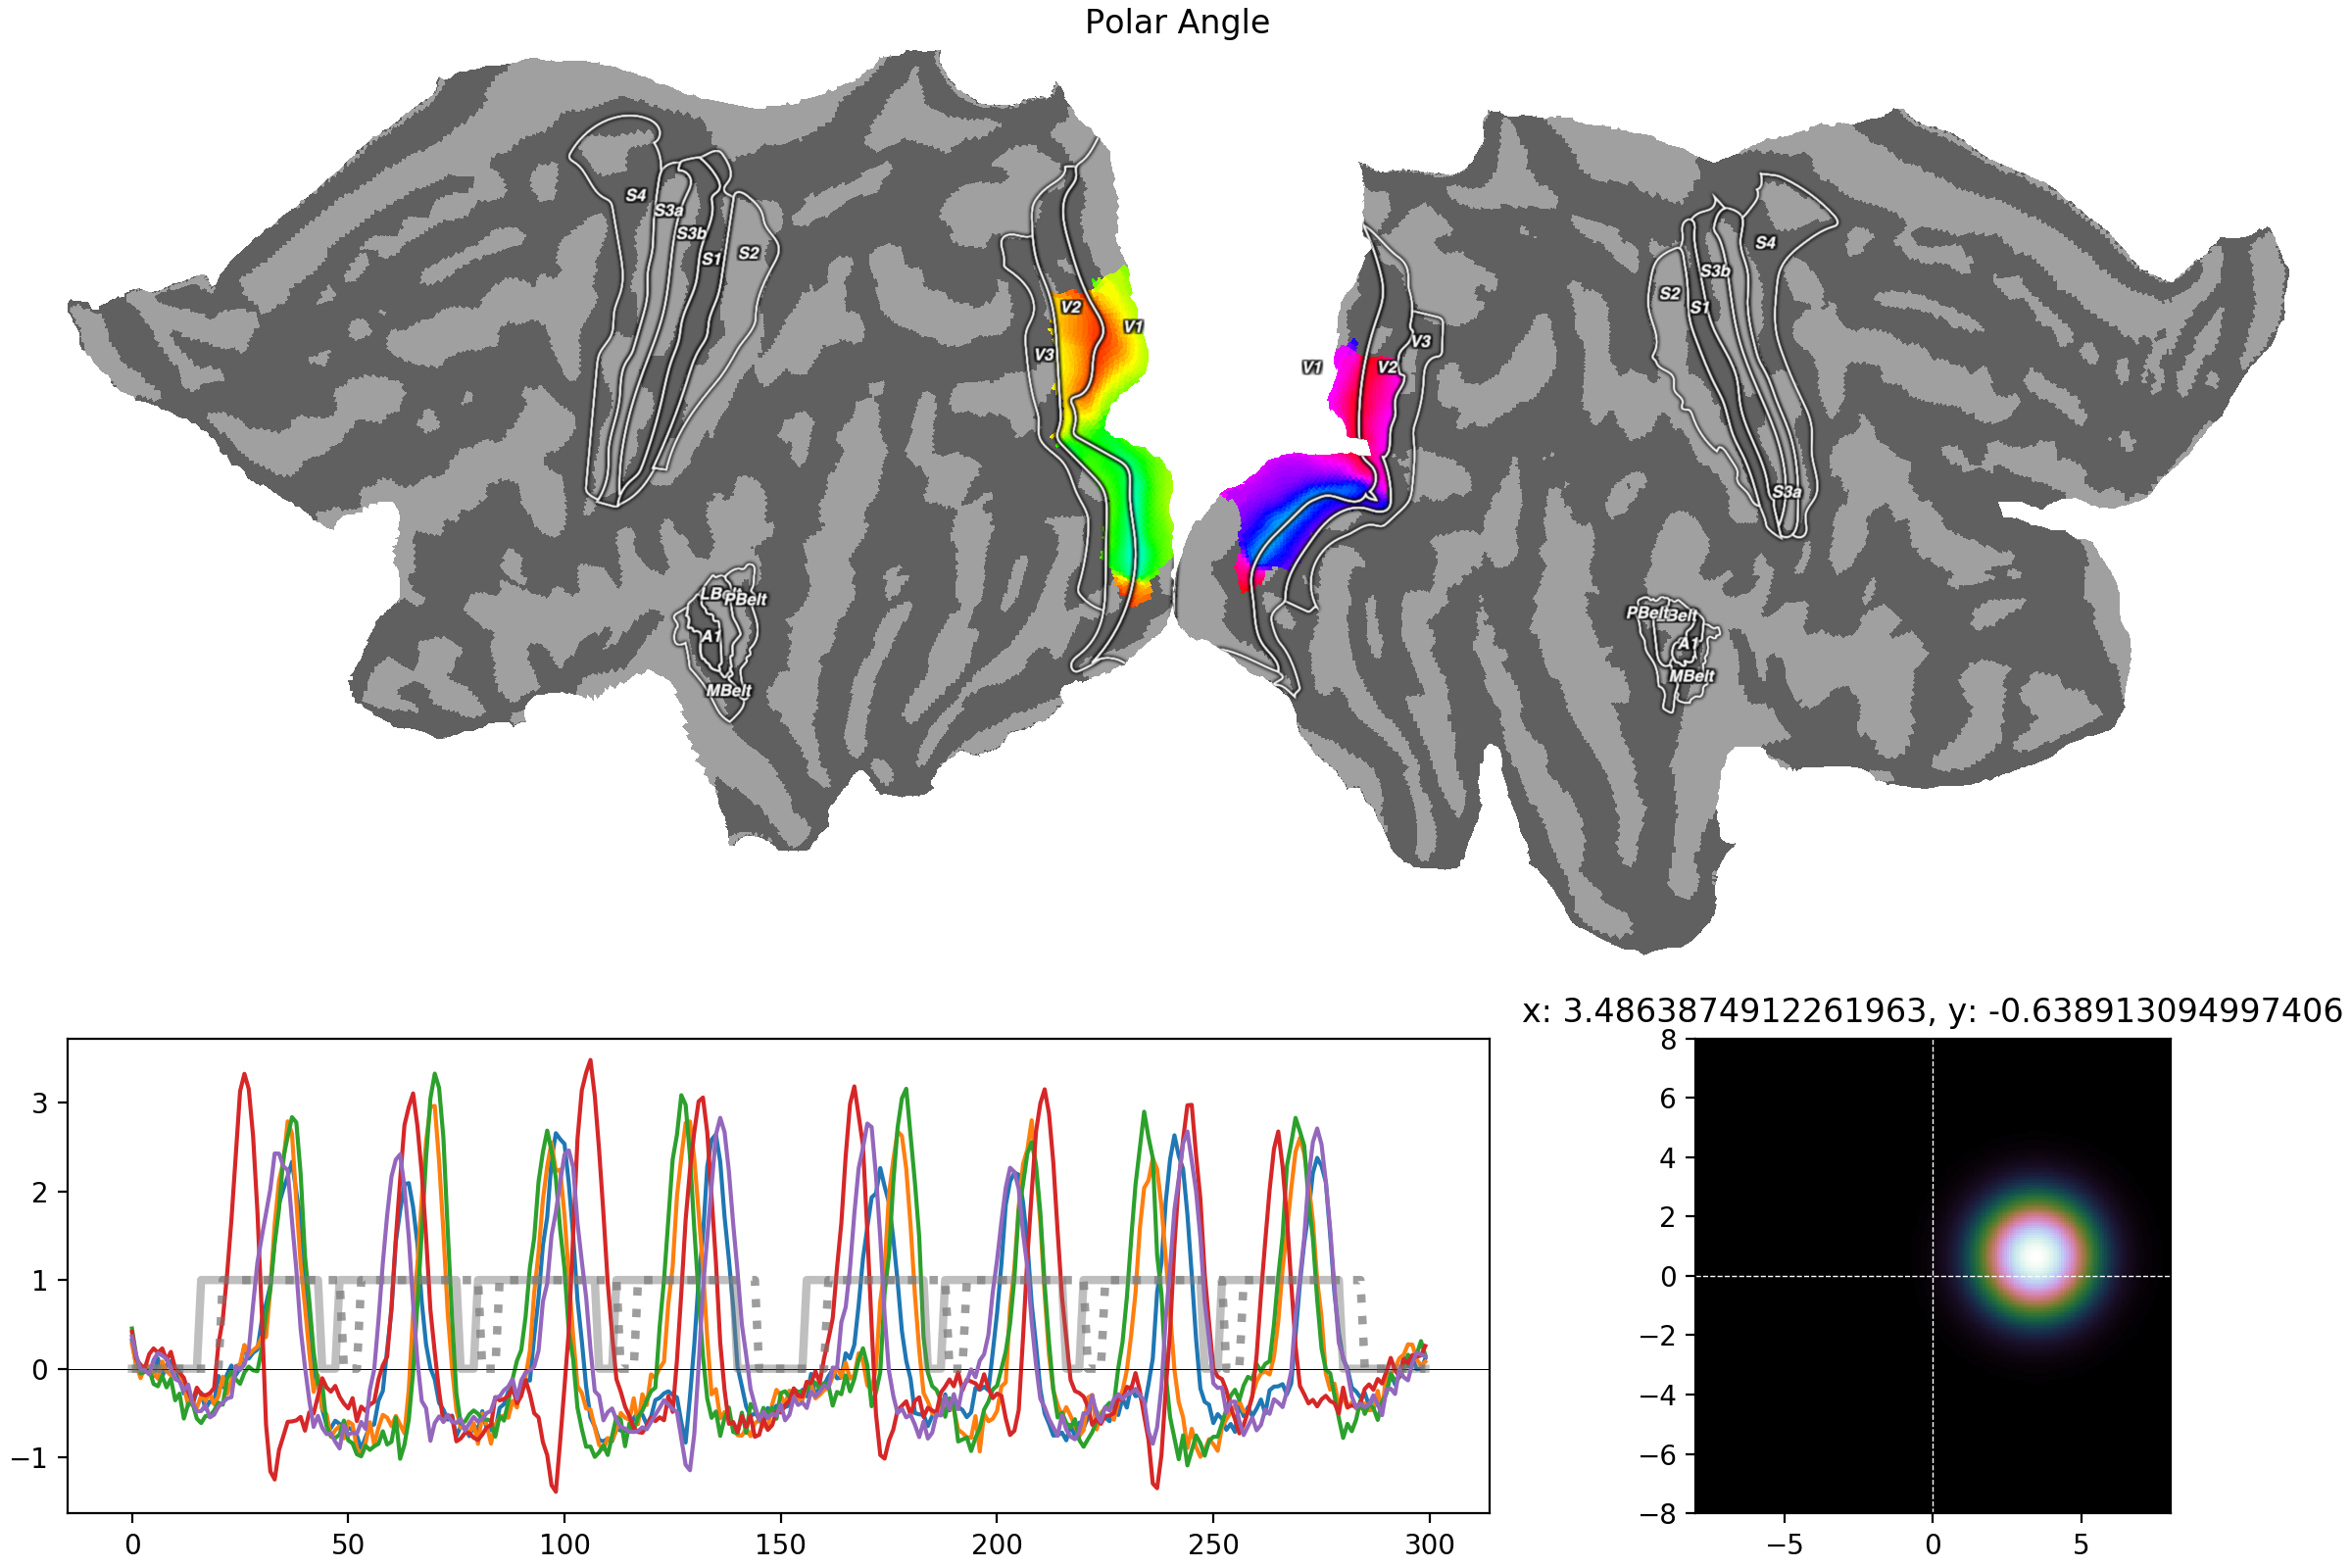

** (org.inkscape.Inkscape:10138): WARNING **: 15:08:05.210: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:10138): WARNING **: 15:08:05.210: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:10138): WARNING **: 15:08:05.210: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:10138): WARNING **: 15:08:05.210: attribute 'clip-path' given as CSS
Fontconfig warning: ignoring UTF-8: not a valid region tag
Background RRGGBBAA: ffffff00
Area 0:0:2511.29:1024 exported to 2511 x 1024 pixels (96 dpi)


8

In [7]:
full_fig = plt.figure(constrained_layout=True, figsize=full_figsize)
gs = full_fig.add_gridspec(3, 3)
flatmap_ax = full_fig.add_subplot(gs[:2, :])
timecourse_ax = full_fig.add_subplot(gs[2, :2])
prf_ax = full_fig.add_subplot(gs[2, 2])

flatmap_ax.set_title('flatmap')
timecourse_ax.set_title('timecourse')
prf_ax.set_title('prf')

###################################################################################################
###################################################################################################
#######
# redraw per-vertex data
#######
###################################################################################################
###################################################################################################

def redraw_vertex_plots(vertex, refresh):
    if refresh:
        timecourse_ax.clear()
    timecourse_ax.axhline(0, color='black', lw=0.25)
    timecourse_ax.plot(tc_data[vertex])
    timecourse_ax.plot(sos, alpha=0.125, lw=3, color='gray')
    timecourse_ax.plot(np.roll(sos,5), alpha=0.25, ls=':', lw=3, color='gray')


    if prf_pars_df['beta'][vertex] != 0:
        # implement plotting of model predictions using the Iso2DGaussianModel class
        # at some point
        pass

    prf = gauss2D_iso_cart(prf_space_x,
                           prf_space_y,
                           [prf_pars_df['x'][vertex],
                            prf_pars_df['y'][vertex]],
                           prf_pars_df['size'][vertex])
    prf_ax.clear()
    prf_ax.imshow(prf, extent=vf_extent+vf_extent, cmap='cubehelix')
    prf_ax.axvline(0, color='white', linestyle='dashed', lw=0.5)
    prf_ax.axhline(0, color='white', linestyle='dashed', lw=0.5)
    prf_ax.set_title(f"x: {prf_pars_df['x'][vertex]}, y: {prf_pars_df['y'][vertex]}")

def zoom_to_roi(axis, subject, roi, hem, margin=10.0):
    roi_verts = cx.get_roi_verts(subject, roi)[roi]
    roi_map = cx.Vertex.empty(subject)
    roi_map.data[roi_verts] = 1

    (lflatpts, lpolys), (rflatpts, rpolys) = cx.db.get_surf(subject, "flat",
                                                            nudge=True)
    sel_pts = dict(left=lflatpts, right=rflatpts)[hem]
    roi_pts = sel_pts[np.nonzero(getattr(roi_map, hem))[0], :2]

    xmin, ymin = roi_pts.min(0) - margin
    xmax, ymax = roi_pts.max(0) + margin
    print([xmin, xmax, ymin, ymax])
    axis.axis([xmin, xmax, ymin, ymax])

    return [xmin, xmax, ymin, ymax]

###################################################################################################
###################################################################################################
#######
# actual callback functions
#######
###################################################################################################
###################################################################################################

def onclick(event):
    if event.inaxes == flatmap_ax:
        xmin, xmax = flatmap_ax.get_xbound()
        ax_xrange = xmax-xmin
        ymin, ymax = flatmap_ax.get_ybound()
        ax_yrange = ymax-ymin

        rel_x = int(mask.shape[0] * (event.xdata-xmin)/ax_xrange)
        rel_y = int(mask.shape[1] * (event.ydata-ymin)/ax_yrange)
        clicked_pixel = (rel_x, rel_y)

        clicked_vertex = vc[int(
            mask_index[clicked_pixel[0], clicked_pixel[1]])]

        redraw_vertex_plots(clicked_vertex.indices[0], (event.key == 'shift'))
        plt.draw()


def onkey(event):
    if event.key == '1':  # polar angle
        cx.quickshow(polar_v, with_rois=True, with_curvature=True,
                     fig=flatmap_ax, with_colorbar=False)
        flatmap_ax.set_title('Polar Angle')
    elif event.key == '2':  # eccentricity
        cx.quickshow(eccen_v, with_rois=True, with_curvature=True,
                     fig=flatmap_ax, with_colorbar=False)
        flatmap_ax.set_title('Eccentricity')
    elif event.key == '3':  # polar angle
        cx.quickshow(size_v, with_rois=True, with_curvature=True,
                     fig=flatmap_ax, with_colorbar=False)
        flatmap_ax.set_title('pRF Size')
    elif event.key == '4':  # polar angle
        cx.quickshow(x_v, with_rois=True, with_curvature=True,
                     fig=flatmap_ax, with_colorbar=False)
        flatmap_ax.set_title('pRF X')
    elif event.key == '5':  # polar angle
        cx.quickshow(y_v, with_rois=True, with_curvature=True,
                     fig=flatmap_ax, with_colorbar=False)
        flatmap_ax.set_title('pRF Y')        
    plt.draw()
    
###################################################################################################
###################################################################################################
#######
# start
#######
###################################################################################################
###################################################################################################
# start with polar angle.
cx.quickshow(polar_v, with_rois=True, with_curvature=True,
             fig=flatmap_ax, with_colorbar=False)

# new_bounds  = zoom_to_roi(axis=flatmap_ax, subject=subject,
#             roi='V2', hem='left', margin=10.0)

full_fig.canvas.mpl_connect('button_press_event', onclick)
full_fig.canvas.mpl_connect('key_press_event', onkey)
# plt.show()
# plt.ion()